In [1]:
%matplotlib widget

import platform
import psutil
import time
from pacti.terms.polyhedra import *
import numpy as np
from schedulability import *

from p_tqdm import p_map, p_umap
from scipy.stats import qmc

import pickle

Having generated 5-step scenario variants, we now turn to analyzing their schedulability with respect to variations of operational requirements as constraints on the system behavior. 

In [2]:
op_l_bounds = [
    90.0,  # power: low range of initial soc
    5.0,   # power: low range of exit soc at each step
    5.0,   # alloc: low range of delta t
    60.0,  # sci: low range of d
    40.0,  # nav: low range of u
]
op_u_bounds = [
    100.0,  # power: high range of initial soc
    30.0,   # power: low range of exit soc at each step
    100.0,  # alloc: high range of delta t
    100.0,  # sci: high range of  d
    90.0,   # nav: high range of  u
]

We use the Latin Hypercube sampler to generate `m` random combinations of requirement hyper-parameters. Schedulability analysis entails checking the compatibility of each of the `m` operational requirement variations against each of the  `n5` 5-step scenario variations previously created. For a given scenario contract, this compatibility check involves merging the contracts for each of the `m` operational requirements variations. The success of the contract merge operation determines the schedulability of the given scenario contract under the given operational requirements. To provide diagnostic feedback about non-schedulable combinations, we break down the operational requirements into 3 sets of requirement constraints that we merge successively until either all are merged or one of the requirement constraints fails to merge. In the latter case, we record the requirement constraint that cannot be merged as an explanation for the non-schedulable combination. 

We've observed that this iterative contract merge for all combinations of scenario and requirement contracts does not scale as nicely as scenario generation since the CPU utilization hovers just above 20% despite the large collection of independent combinations to analyze. This is due in part to the fact each schedulability analysis involves up to 3 contract merge operations whereas each 5-step scenario variant generation required creating 23 contracts combined via 12 contract composition and 5 contract merge operations. That is, there is significant overhead in parallelizing computationally small processes.

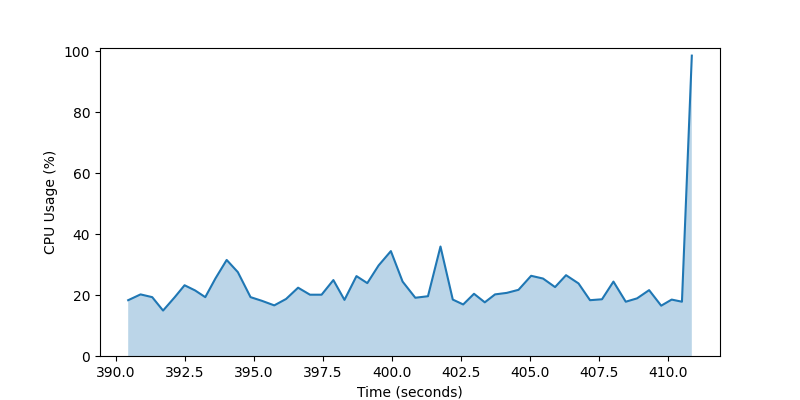

Output()

Found 1210 admissible and 58790 non-admissible schedules out of 60000 combinations generated from 300 variations of operational requirements for each of the 200 scenarios.
Total time 410.94391417503357 running on AMD Ryzen Threadripper PRO 3955WX 16-Cores @ 3.8927 GHz with up to 32 threads.



In [3]:
op_sampler: qmc.LatinHypercube = qmc.LatinHypercube(d=len(op_l_bounds))

m = 300

op_sample: np.ndarray = op_sampler.random(n=m)
scaled_op_sample: np.ndarray = qmc.scale(sample=op_sample, l_bounds=op_l_bounds, u_bounds=op_u_bounds)

s5 = open("scenarios5.data", "rb")
scenarios5 = pickle.load(s5)
s5.close()

srs = [(scenario, req) for scenario in scenarios5 for req in scaled_op_sample]

from cpu_usage_plot import *
with cpu_usage_plot():
    ta = time.time()
    all_results5: List[schedule_result_t] = p_umap(schedulability_analysis5, srs)
    tb = time.time()

results5: schedule_results_t = aggregate_schedule_results(all_results5)
print(
    f"Found {len(results5[1])} admissible and {len(results5[0])} non-admissible schedules out of {len(scaled_op_sample)*len(scenarios5)} combinations generated from {len(scaled_op_sample)} variations of operational requirements for each of the {len(scenarios5)} scenarios.\n"
    f"Total time {tb-ta} running on {cpu_info_message}\n"
)

f = open("results5.data", "wb")
pickle.dump(results5, f)
f.close()

The results above indicate that about 2% of all 60,000 combinations of 5-steps scenario variants and operational requirement variants yield admissible schedules. Even though the schedulability analysis of short scenarios involves significant overhead that limits the effectiveness of parallelism, obtaining these results under 7 minutes makes Pacti a very effective tool for finding solutions compatible with arbitrary operational constraints.